In [1]:
library(tidyverse)
library(cowplot)
library(martini)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# GS network

In [2]:
load("cones.gs.RData")
gs <- cones

sum(gs$selected)

[1] 1248

Warning message:
"Removed 25 rows containing non-finite values (stat_binhex)."

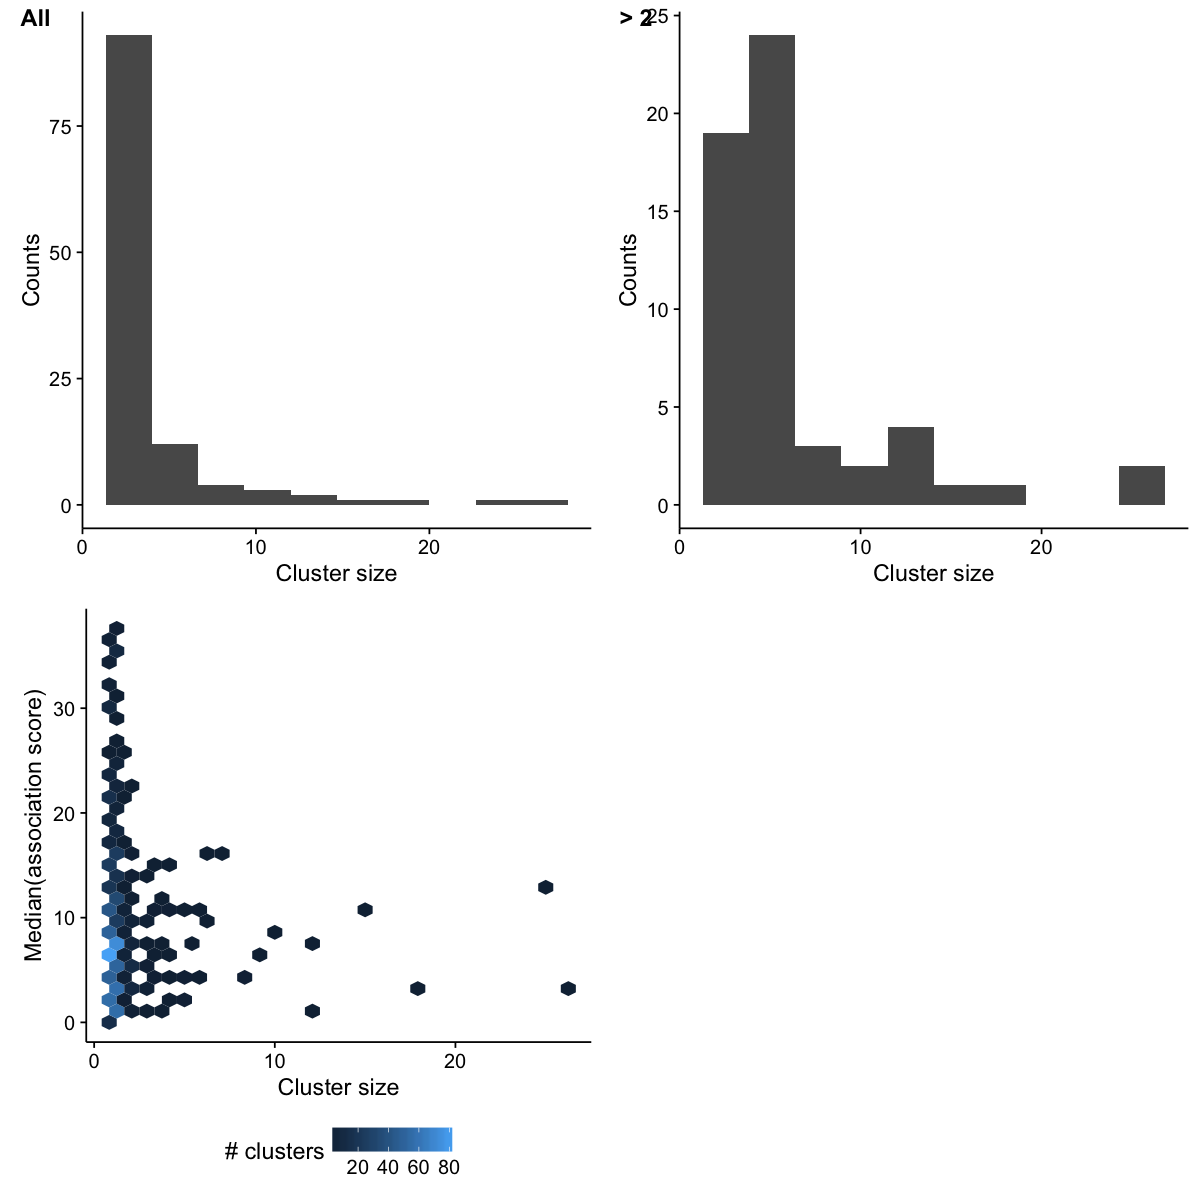

In [3]:
getSizes <- function(cones) {
    cones %>%
        filter(selected) %>%
        group_by(cluster, chr) %>%
        summarise(size = n(), C = median(c)) %>%
        arrange(-size)
}

peekClusters <- function(cones) {
    clusterSize <- getSizes(cones)

    all <- clusterSize %>%
        filter(size > 1) %>%
        ggplot(aes(x = size)) +
            geom_histogram(bins = 10) +
            labs(x = "Cluster size", y = "Counts")

    gt2 <- clusterSize %>%
        filter(size > 2) %>%
        ggplot(aes(x = size)) +
            geom_histogram(bins = 10) +
            labs(x = "Cluster size", y = "Counts")

    sizeVSc <- ggplot(clusterSize, aes(x = size, y = C)) +
        stat_binhex() +
        labs(x = "Cluster size", y = "Median(association score)", fill = "# clusters") +
        theme(legend.position="bottom")

    options(repr.plot.width=10, repr.plot.height=10)
    plot_grid(all, gt2, sizeVSc, labels=c("All","> 2"))
}

peekClusters(gs)

Most of the clusters have small sizes (1,2 SNPs). However, it seems that small clusters have a similar association scores as bigger clusters, so I am inclined to think that bigger clusters are not picked despite being having lower association scores, but because they happen to connect high-score SNPs.

In [4]:
head(getSizes(gs), n = 20)

cluster,chr,size,C
586,8,26,2.822394
506,8,25,12.597872
280,3,18,3.684915
394,5,15,10.745120
370,5,14,NA
392,5,14,NA
50,3,12,7.479093
527,8,12,1.232985
43,3,10,8.453581
52,3,9,6.400978


It seems that the biggest clusters come from only 3 chromosomic regions in chromosomes 3, 5 and 8.

[1] TRUE

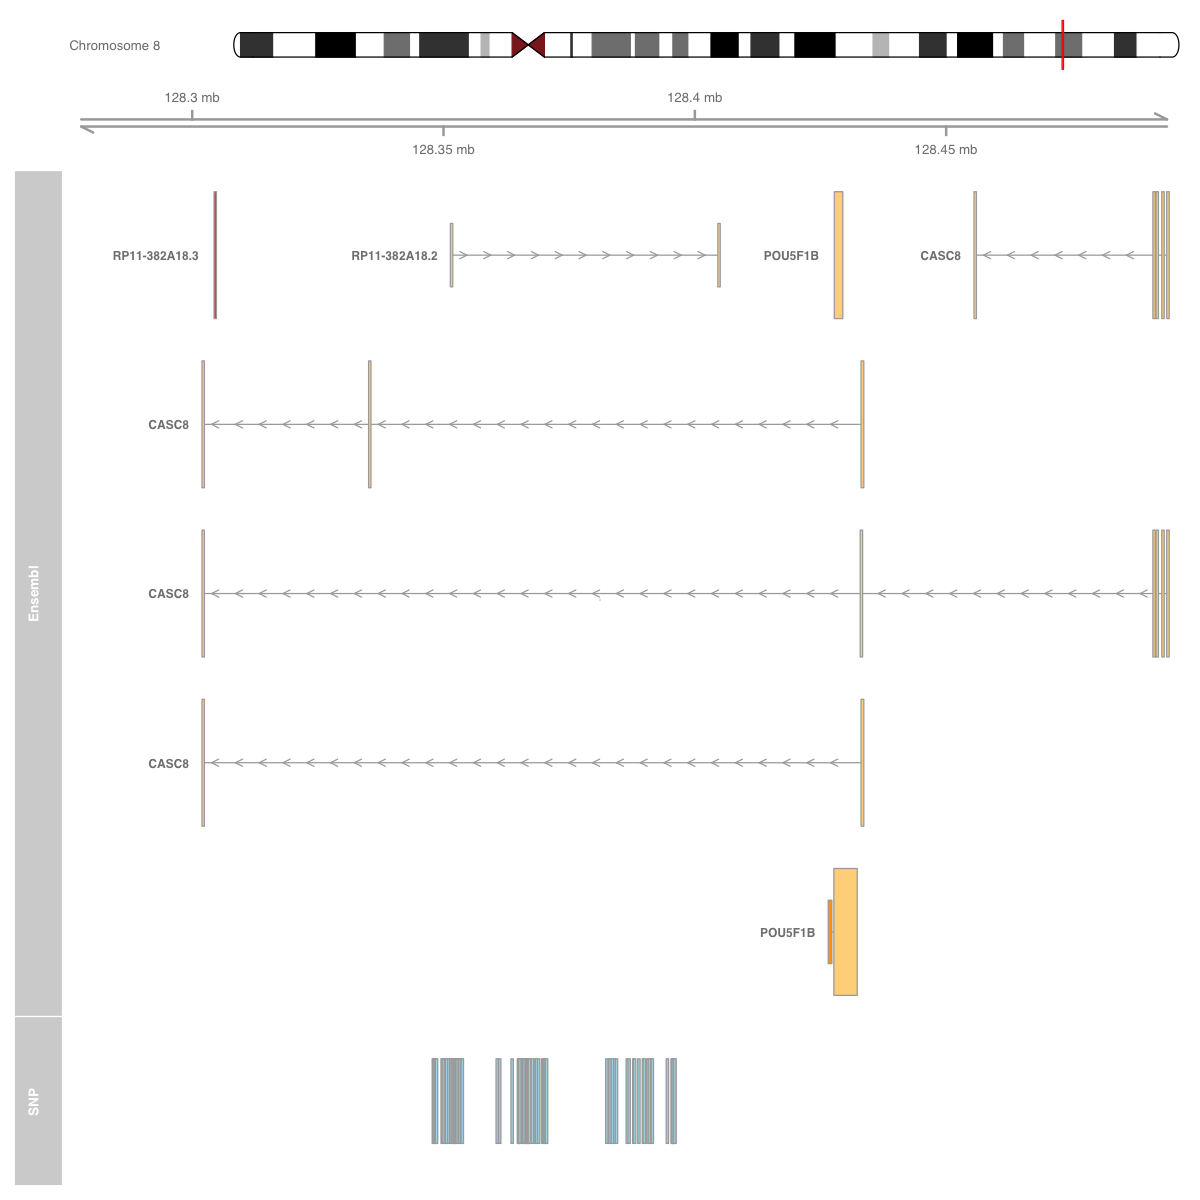

In [5]:
plot_snp_cluster(gs, head(getSizes(gs), n = 20) %>% filter(chr == 8) %>% .$cluster)

In chromosome 8 we find gene CASC8, which had appreared in previous analyses.

[1] TRUE

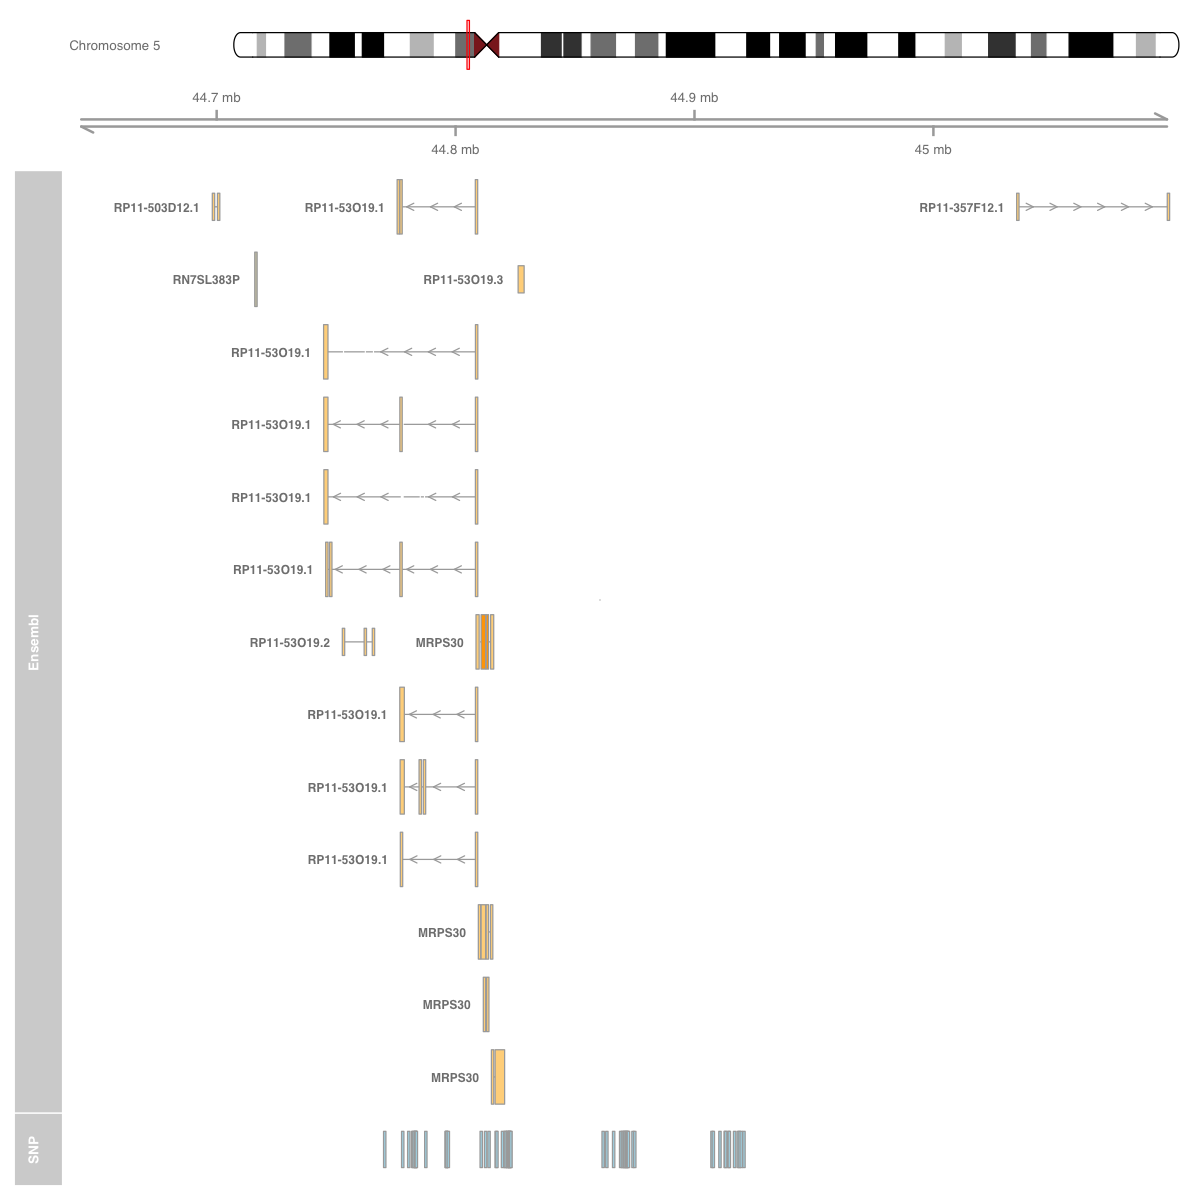

In [6]:
plot_snp_cluster(gs, head(getSizes(gs), n = 20) %>% filter(chr == 5) %>% .$cluster)

In this region we find two compelling genes: MRPS30, the S30 subunit of the mitochondrial ribosome and potentially involved in energetic metabolism; and, more interestingly, RP11-53O19.1, also known as Breast Cancer-Associated Transcript 54, a ncRNA.

[1] TRUE

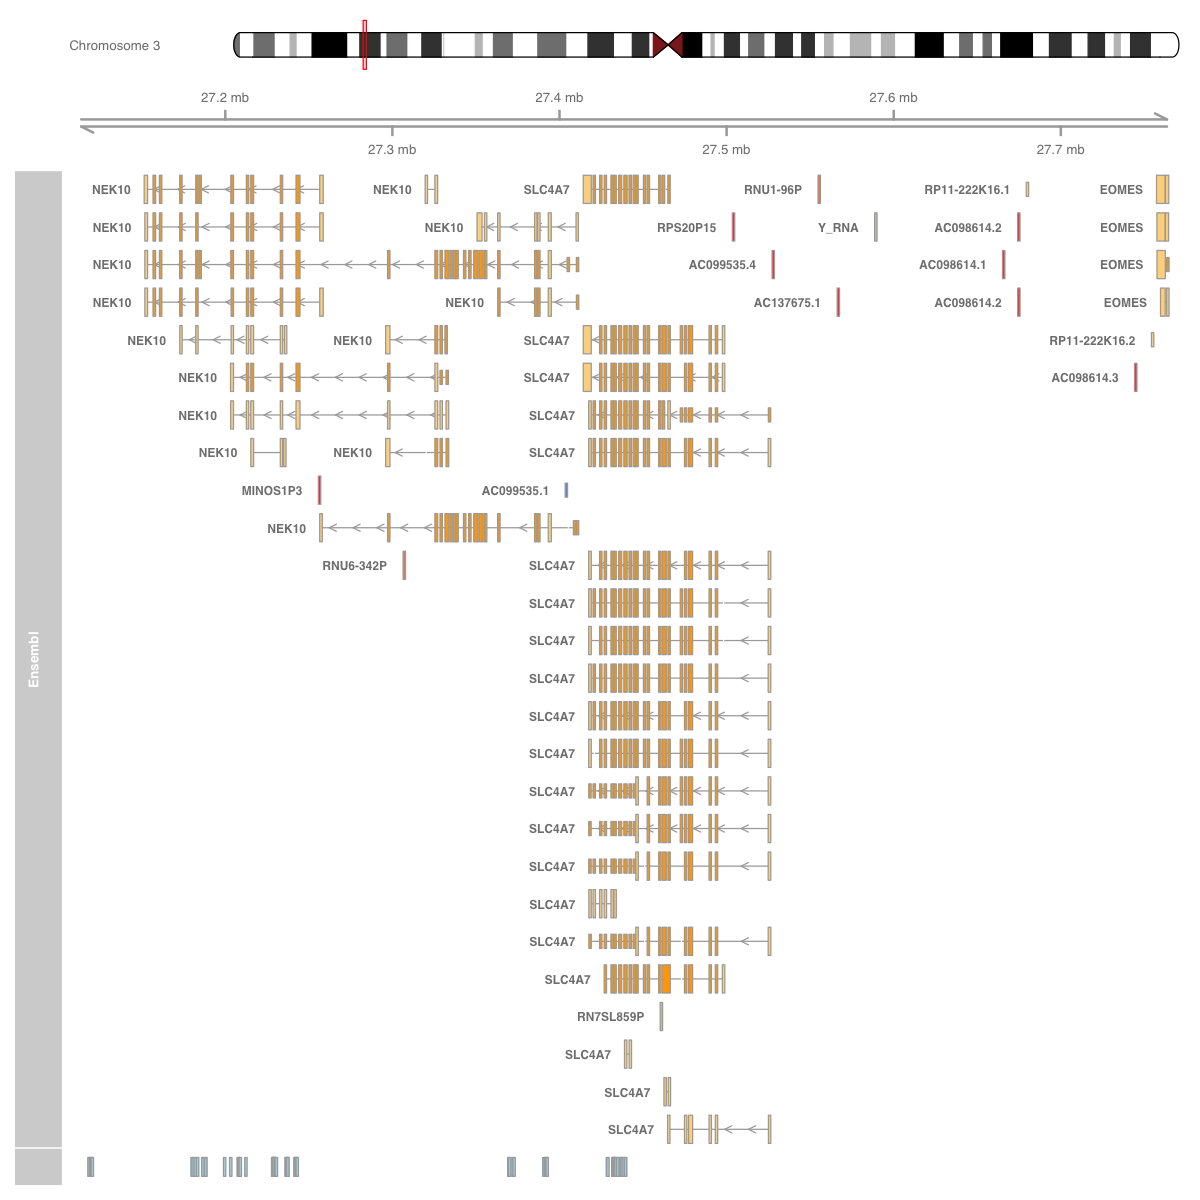

In [7]:
plot_snp_cluster(gs, head(getSizes(gs), n = 20) %>% filter(chr == 3) %>% .$cluster)

Here we retrieve our old-friend NEK10, a protein kinase involved in cell-cycle controlwhich was already linked to BRCA susceptibility. Interestingly, we don't recover FGFR2 among these top clusters

# GM network

In [8]:
load("cones.gm.RData")
gm <- cones

sum(gm$selected)

[1] 1091

Warning message:
"Removed 25 rows containing non-finite values (stat_binhex)."

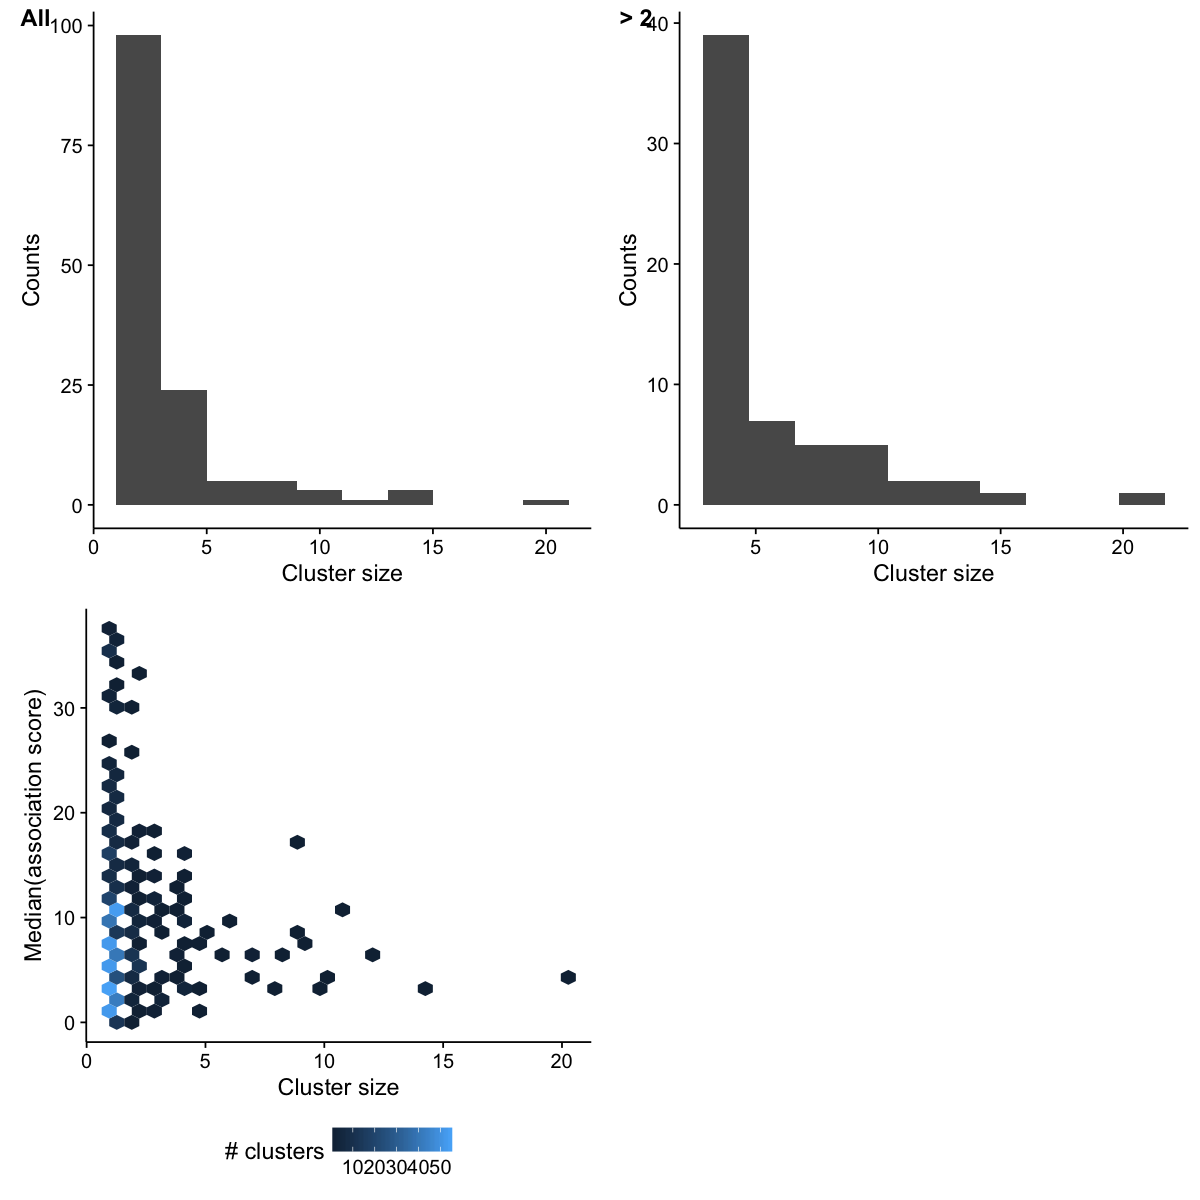

In [9]:
peekClusters(gm)

In [10]:
head(getSizes(gm), n = 20)

cluster,chr,size,C
399,3,20,3.905365
313,3,15,NA
287,3,14,NA
418,3,14,3.519701
39,3,12,7.086028
461,5,11,10.628520
41,3,10,3.170767
462,5,10,4.163540
296,3,9,8.135196
312,3,9,7.963262


Only 2 chromosomic regions here, in chromosomes 3 and 5, around the regions we already described.

[1] TRUE

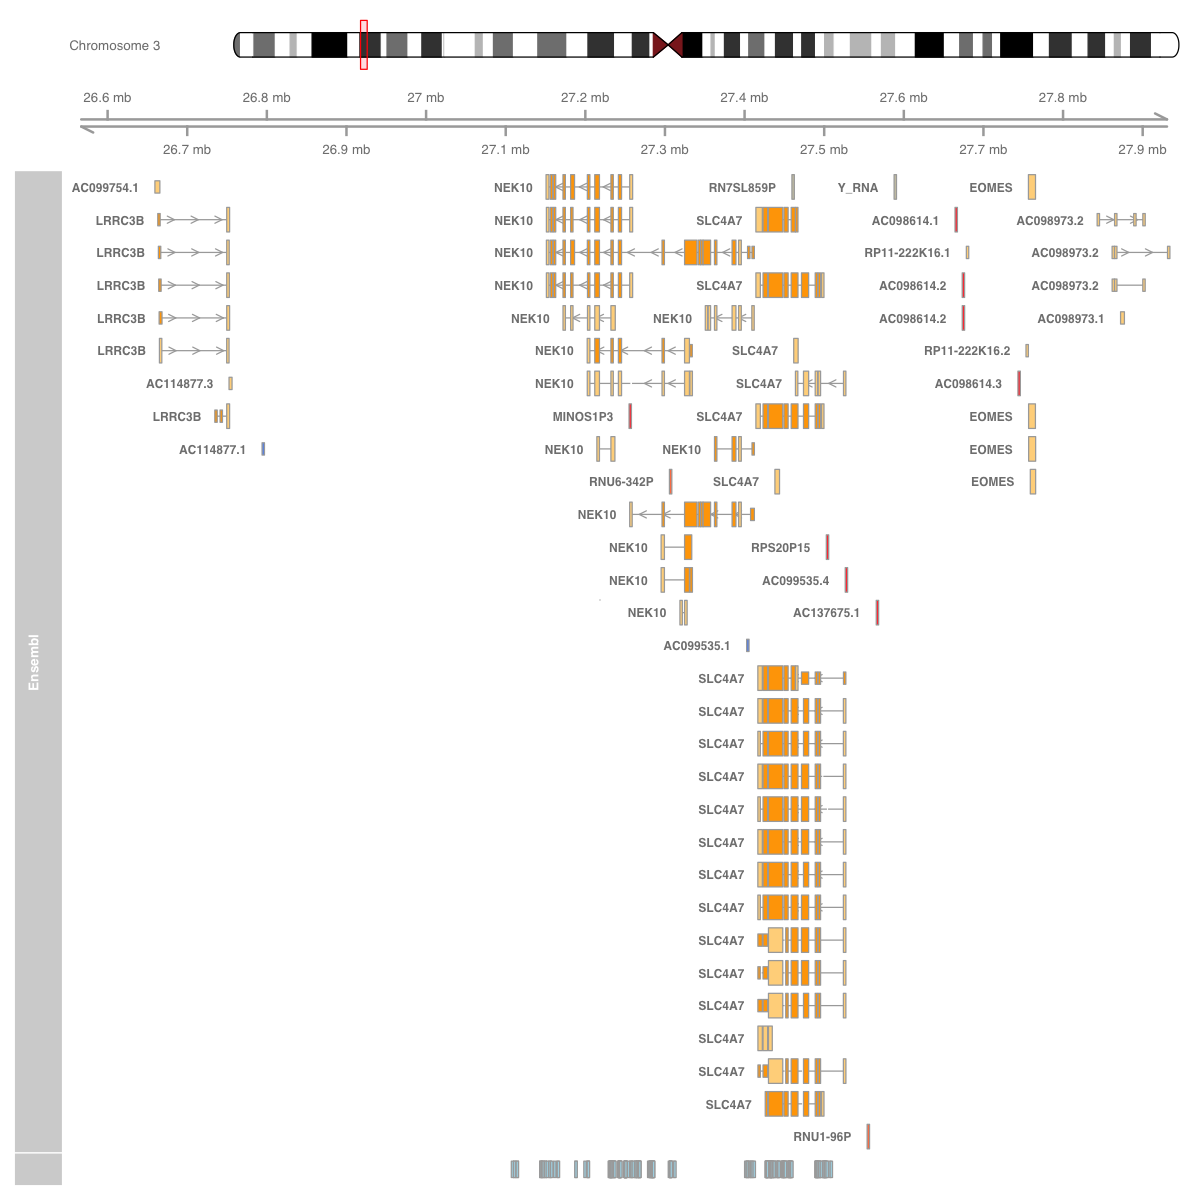

In [11]:
plot_snp_cluster(gm, head(getSizes(gm), n = 20) %>% filter(chr == 3) %>% .$cluster)

[1] TRUE

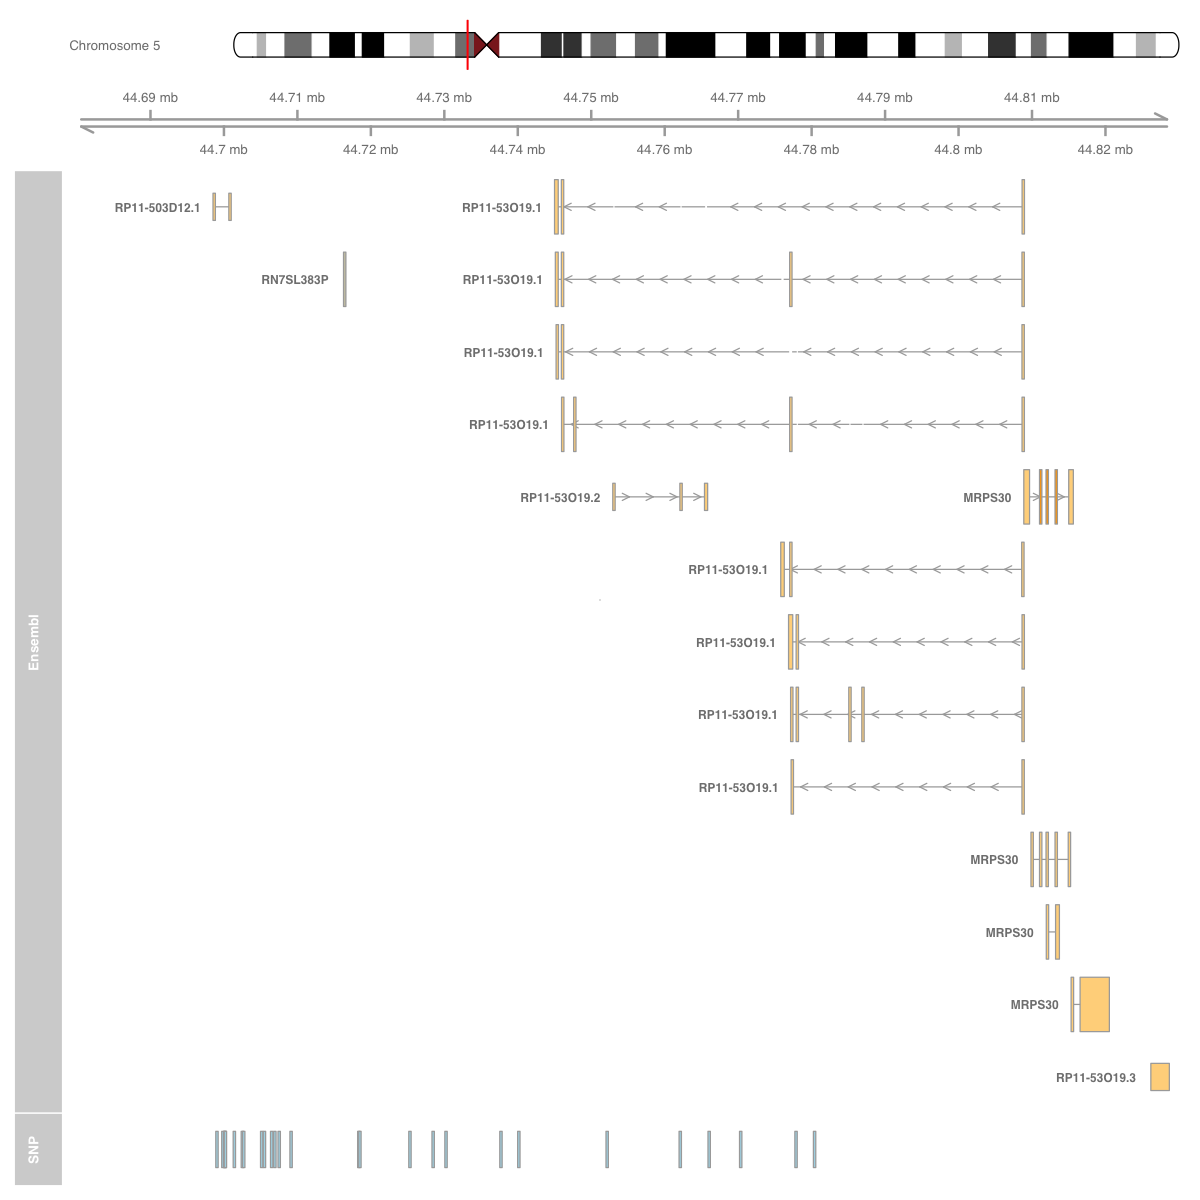

In [12]:
plot_snp_cluster(gm, head(getSizes(gm), n = 20) %>% filter(chr == 5) %>% .$cluster)

# GI network

In [13]:
load("cones.gi.RData")
gi <- cones

sum(gi$selected)

[1] 2227

Warning message:
"Removed 53 rows containing non-finite values (stat_binhex)."

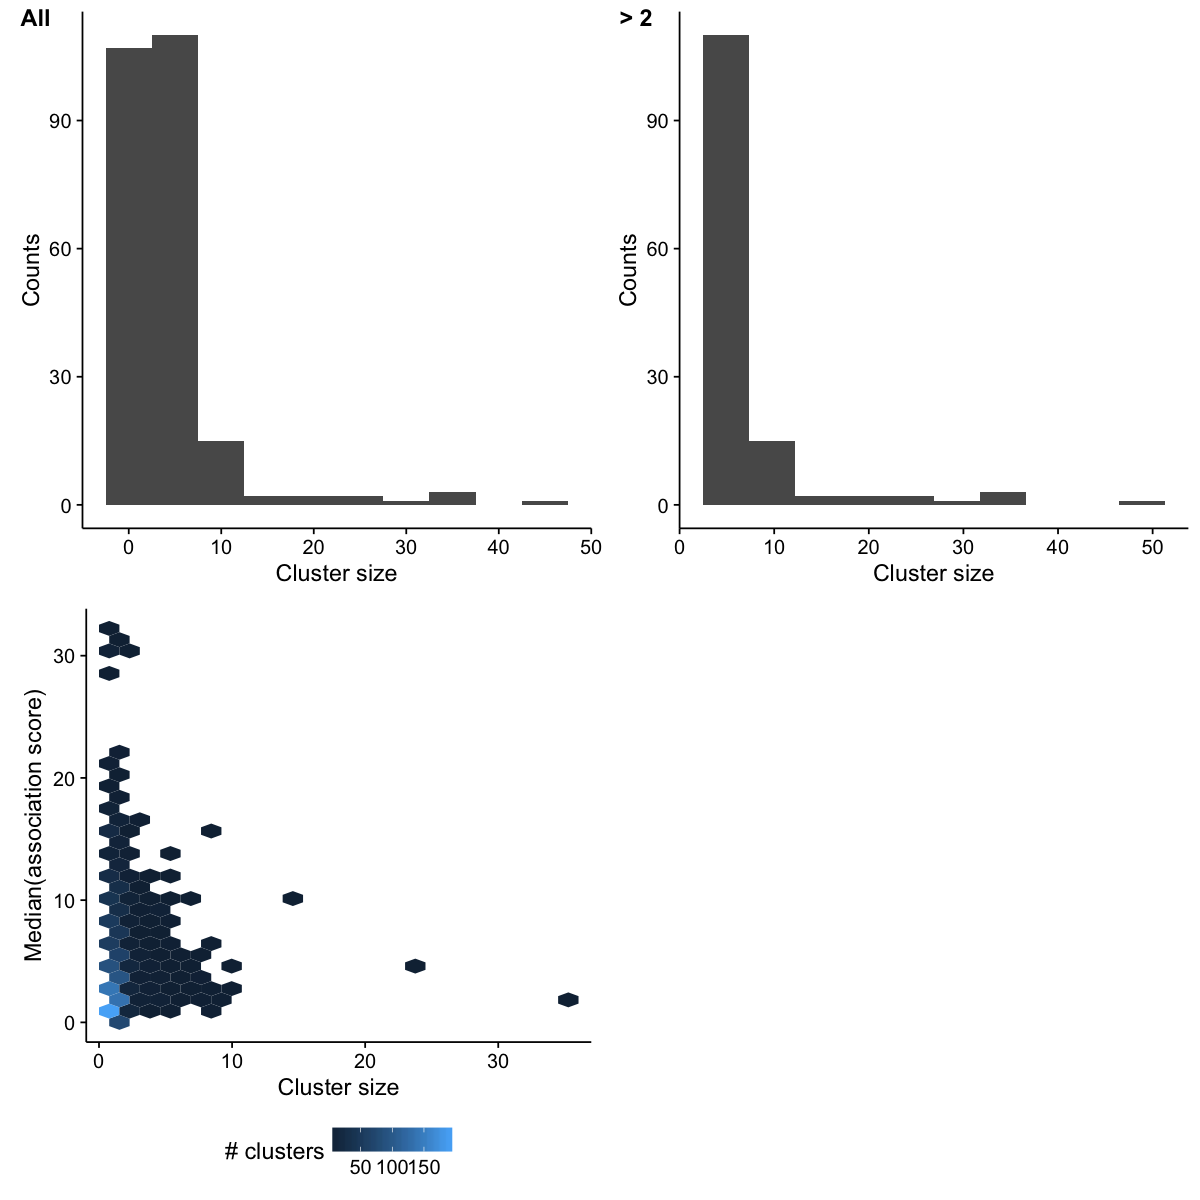

In [14]:
peekClusters(gi)

In [15]:
head(getSizes(gi), n = 20)

cluster,chr,size,C
1,5,47,NA
1,3,35,NA
1,8,35,2.037973
1,2,33,NA
73,5,30,NA
1,10,24,4.366318
1,16,23,NA
1,7,22,NA
204,3,19,NA
764,5,15,NA


In [ ]:
load("../../datasets/genesis/gi.net")
plot_ideogram(gi, net)

# Consistency

How consistent are the selected SNPs in the different networks?

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

consistency <- gs %>%
    rename(GS = selected) %>%
    mutate(GM = gm$selected,
           GI = gi$selected) %>%
    mutate(consistency = GS + GM + GI)

consistency %>%
    filter(consistency != 0) %>%
    gather(net, selected, GS, GM, GI) %>%
    ggplot(aes(x = net, y = as.character(pos), fill = ifelse(selected, "Yes", "No"))) +
        geom_tile() +
        labs(x = "Network", y = "Genome position", fill = "Selected") +
        scale_fill_manual(values=c("Yes"="gray20", "No"="gray90")) +
        theme(axis.text.y = element_blank(),
              axis.ticks.y = element_blank()) +
        facet_grid(chr ~ ., scales = "free")

GI network selects twice as many SNPs as the GM and the GS networks. As we see, most of the SNPs selected in the GS are selected in GS, and most of the ones selected in GM (+ many more) are selected in GI. Interestingly, as we can see from the circos above, GI network provides a way of connecting the previously isolated chromosomic regions in 3, 5 and 8 (and some potentially interesting regions in chromosomes 10 and 16).

# Validation: BCAC

We want to put SConES results in the context of another dataset, to see what the SNPs look like. We selected for that the European cohort of the BCAC ([download](http://bcac.ccge.medschl.cam.ac.uk/bcacdata/icogs/)). Note that (low-powered) GWAS have issues with replication, so low p-values in one experiment doesn't imply low p-values in another one.

In [ ]:
bcac <- read_tsv("../../datasets/icogs_bcac_public_results_euro.lite.txt", col_types = "cd") %>%
    merge(consistency, by.x = "phase3_1kg_id", by.y = "snp", all.y = T)

bp <- bcac %>%
    filter(!is.na(bcac_icogs1_risk_P1df)) %>%
    ggplot(aes(x = as.character(consistency), y = -log10(bcac_icogs1_risk_P1df))) +
        geom_boxplot() +
        labs(x = "+ experiments", y = "-log10(BCAC p-value)")

h <- bcac %>%
    filter(is.na(bcac_icogs1_risk_P1df)) %>%
    ggplot(aes(x = consistency)) +
        geom_histogram(bins = 4) +
        scale_y_log10() +
        labs(x = "+ experiments", y = "Count")

options(repr.plot.width=10, repr.plot.height=5)
plot_grid(bp, h, labels=c("! NA","NA"))

It looks like we are selecting SNPs with very low p-values in the BCAC dataset too. This reinforces the This can be read in two positive ways:

- These SNPs are also moderately associated in GENESIS too, not enough to get a good, low-univariate p-value, but enough for SConES to pick up.
- SNPs with low p-values are connected in the underlying network, that's why SConES is picking them up, reinforcing our hypothesis.

In [ ]:
bcac %>%
    filter(consistency > 0) %>%
    ggplot(aes(x = pos, y = -log10(bcac_icogs1_risk_P1df), color = as.character(consistency))) +
        geom_point(alpha = 0.8) +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(BCAC p-value)", color = "+ experiments") +
        scale_color_manual(values = c("1"="#edf8b1", "2"="#7fcdbb", "3"="#2c7fb8")) +
        facet_grid(. ~ chr, scales = "free_x")

The low-p-values are mostly concentrated in the chromosomic regions identified above in chromosomes 3, 5 and 8. But also regions in chromosome 10 and 16.